# Version 3 of the Model - Transformers (BERT)

- IMPORTS

In [15]:
# Imports
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers.experimental import Adam
from sklearn.model_selection import train_test_split
from keras.metrics import Precision, Recall, AUC
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras import Sequential
from keras.utils import to_categorical
from nltk.corpus import stopwords
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import transformers
import numpy as np
import warnings
import spacy
import nltk
import math

In [16]:
warnings.filterwarnings('ignore')
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [17]:
# Loading training data
training_data = pd.read_csv('dados_treino.txt', header=None, delimiter=';')

# Loading test data
training_test = pd.read_csv('dados_teste.txt', header=None, delimiter=';')

# Adjusting column names
training_data = training_data.rename(columns={0:'text', 1:'feeling'})
training_test = training_test.rename(columns={0:'text', 1:'feeling'})

In [18]:
# Looking at the shape of the data
print('Training: ', training_data.shape)
print('Test: ', training_test.shape)

Training:  (16000, 2)
Test:  (2000, 2)


In [19]:
# Feelings present in training data
print('Data of training ', training_data['feeling'].value_counts())
# feelings presentes nos dados de teste
print('Data of test', training_test['feeling'].value_counts())

Data of training  feeling
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64
Data of test feeling
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64


## Text data pre-processing

In [20]:
# Downloading the dictionary to simplify the text
!python -m spacy download en_core_web_md -q

# Loading the dictionary
dict_nlp = spacy.load('en_core_web_md')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [21]:
# Creating a function that will receive text as a parameter to be "simplified"
def simplifies_text(text):
    
    # Process the text using the dictionary
    doc = dict_nlp(text)

    # Creates a list of lemmas from the tokens, converted to lowercase and without whitespace,
    # And excluding words that are stopwords
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]

    # Returns the processed tokens as a single string, joining them with spaces
    return ' '.join(tokens)


# Applying the function to training data
training_data['processed_text'] = training_data['text'].apply(simplifies_text)

# Applying the function to test data
training_test['processed_text'] = training_test['text'].apply(simplifies_text)

# Viewing the data
training_data.head()

,text,feeling,processed_text
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [22]:
# Function to encode text into a sequence of integers for BERT model input
def tkn_encode(texts, tokenizer, chunk_size = 256, maxlen = 512):
    
    # Enable truncation in the tokenizer to a specified maximum length
    tokenizer.enable_truncation(max_length = maxlen)
    
    # Enable padding in the tokenizer to a specific length
    tokenizer.enable_padding(length = maxlen)
    
    # Initialize a list to store the encoded IDs
    all_ids = []
    
    # iterate over the texts in chunks of size 'chunk_size'
    for i in tqdm(range(0, len(texts), chunk_size)):
        
        # Create a chunk of text
        text_chunk = texts[i:i+chunk_size].tolist()
        
        # Encode the piece of text in batch
        encs = tokenizer.encode_batch(text_chunk)
        
        # Extend the all_ids list with encoded IDs
        all_ids.extend([enc.ids for enc in encs])
        
    # Return the list of IDs as a numpy array
    return np.array(all_ids)

## Loading the Pre-Trained Model Tokenizers from the Huggingface platform

In [23]:
# Load the tokenizer
tokenizador_bert = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

# Save tokenizer and vocabulary locally
tokenizador_bert.save_pretrained('.')

# Load a faster tokenizer using the vocabulary of the main tokenizer
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase = False)

# View the tokenizer
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

## Preparing data for training

In [24]:
# Splitting data into training and validation with stratified sampling
X_training, X_valid, Y_training, Y_valid = train_test_split(training_data['processed_text'].values,
                                                        training_data['feeling'].values,
                                                        test_size = 0.2,
                                                        random_state = 42,
                                                        stratify = training_data['feeling'])

In [25]:
# Maximum length used in text
# We will use the value 100 but the function supports 512 and can be adjusted to more
# In this case, we will only use 100 because of the samples we have
max_length = 100


# Apply encoding (tokenization) to our data, using the fastest tokenizer
X_training_final = tkn_encode(X_training, fast_tokenizer, maxlen = max_length)
X_valid_final = tkn_encode(X_valid, fast_tokenizer, maxlen = max_length)
X_test_final = tkn_encode(training_test['processed_text'].to_numpy(), fast_tokenizer, maxlen = max_length)

100%|██████████| 8/8 [00:00<00:00, 374.14it/s]


In [26]:
# Defining the output data encoder
enc_le_BERT = LabelEncoder()

# Applying the encoder only to training data
Y_training_le = enc_le_BERT.fit_transform(Y_training)
y_valid_le = enc_le_BERT.transform(Y_valid)
y_teste_le = enc_le_BERT.transform(training_test['feeling'])

# Convert the output variable to categorical
Y_training_encoded = to_categorical(Y_training_le)
y_valid_encoded = to_categorical(y_valid_le)
y_teste_encoded = to_categorical(y_teste_le)

# Batch size
BATCH_SIZE = 16

In [27]:
# Prepare training data for tensorflow (tensor) format
dataset_treino = (tf.data.Dataset
    .from_tensor_slices((X_training_final, Y_training_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
)

# Prepare validation data for tensorflow (tensor) format
dataset_valid = (tf.data.Dataset
    .from_tensor_slices((X_valid_final, y_valid_encoded))
    .batch(BATCH_SIZE)
    .cache()
)

# Prepare test data to tensorflow (tensor) format
dataset_teste = (
    tf.data.Dataset
    .from_tensor_slices((X_test_final, y_teste_encoded))
    .batch(BATCH_SIZE)
)

## Fine Tuning of the Transformer Model

In [28]:
# Function for fine-tuning and training the model using a transformer (BERT)
def creates_model(transformer, max_len = 512):
    
    # This first part is all inherited from the BERT architecture
    
   # Setting input layer with maximum sequence size
    input_word_ids = tf.keras.layers.Input(shape = (max_len,),
                                           dtype = tf.int32,
                                           name = "input_word_ids")
    
    # Getting the output from the transformer sequence
    sequence_output = transformer(input_word_ids)[0]
    
    # Selecting the first token of each sequence (CLS token in BERT) for classification
    cls_token = sequence_output[:, 0, :]
    
    # Now let's implement our "head", basically the last layer of the model
    
    # Adding a dense layer to the output with softmax activation for classification
    out = Dense(6, activation='softmax')(cls_token)
    
    # Building the keras model with defined inputs and outputs
    model = tf.keras.Model(inputs = input_word_ids, outputs = out)
    
    # Compiling the model with the Adam optimizer, categorical cross-entropy loss and evaluation metrics
    model.compile(tf.keras.optimizers.legacy.Adam(learning_rate = 1e-5),
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy', Precision(), Recall(), AUC()])
    
    # Returns the compiled model
    return model

## Loading the Pre-Trained model

In [29]:
# Creates an instance of the pre-trained, multilingual DistilBERT model suitable for use with TensorFlow
transformer_layer = (transformers.TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased'))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [30]:
# Create the model with the pre-trained transformer layers and our custom layers for fine-tuning
model_BERT = creates_model(transformer_layer, max_len=max_length)

# Model summary
model_BERT.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 100)]             0         
 )                                                               
                                                                 
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_   134734080 
 stilBertModel)              hidden_state=(None, 100             
                             , 768),                             
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0         
 SlicingOpLambda)                                                
                                                                 
 dense (Dense)               (None, 6)                 4614  

In [31]:
# Defining the first three layers of the model as untrainable
model_BERT.layers[0].trainable=False
model_BERT.layers[1].trainable=False
model_BERT.layers[2].trainable=False

In [32]:
# Hyperparameters
n_steps = X_training_final.shape[0] // BATCH_SIZE
num_epochs = 3

## Training the model

In [33]:
history = model_BERT.fit(dataset_treino,
                            steps_per_epoch = n_steps,
                            validation_data = dataset_valid,
                            epochs = num_epochs)

Epoch 1/3


800/800 [==============================] - 862s 1s/step - loss: 1.1885 - accuracy: 0.5370 - precision: 0.7842 - recall: 0.3285 - auc: 0.8513 - val_loss: 0.4699 - val_accuracy: 0.8416 - val_precision: 0.8835 - val_recall: 0.8059 - val_auc: 0.9763
Epoch 2/3
800/800 [==============================] - 839s 1s/step - loss: 0.3933 - accuracy: 0.8614 - precision: 0.8867 - recall: 0.8360 - auc: 0.9828 - val_loss: 0.3275 - val_accuracy: 0.8797 - val_precision: 0.8973 - val_recall: 0.8681 - val_auc: 0.9876
Epoch 3/3
800/800 [==============================] - 882s 1s/step - loss: 0.2575 - accuracy: 0.9006 - precision: 0.9153 - recall: 0.8885 - auc: 0.9924 - val_loss: 0.2933 - val_accuracy: 0.8928 - val_precision: 0.9009 - val_recall: 0.8838 - val_auc: 0.9890


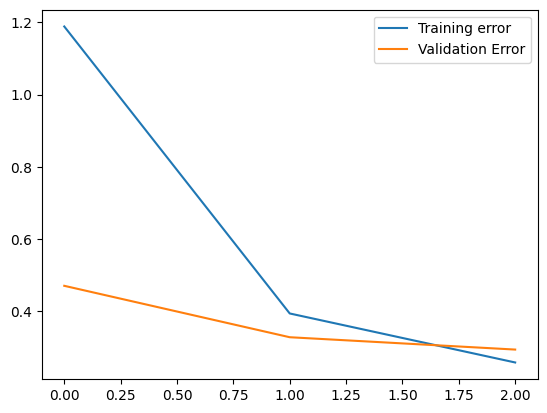

In [34]:
# Learning Crusades
loss, val_loss = history.history['loss'], history.history['val_loss']
plt.plot(loss, label='Training error')
plt.plot(val_loss, label='Validation Error')
plt.legend()
plt.show()

In [35]:
# Predictions
predictions = model_BERT.predict(X_test_final)

# Labels
prediction_labels = predictions.argmax(axis=1)

print(classification_report(y_teste_le, prediction_labels))

63/63 [==============================] - 35s 534ms/step
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       275
           1       0.93      0.83      0.88       224
           2       0.90      0.94      0.92       695
           3       0.80      0.71      0.75       159
           4       0.95      0.92      0.93       581
           5       0.65      0.97      0.78        66

    accuracy                           0.90      2000
   macro avg       0.86      0.88      0.86      2000
weighted avg       0.90      0.90      0.90      2000



In [36]:
# Confusion matrix
print(confusion_matrix(y_teste_le, prediction_labels))

[[248   3   6   4  14   0]
 [  7 186   2   1   3  25]
 [  3   1 654  20   8   9]
 [  1   0  40 113   5   0]
 [ 11   9  24   3 534   0]
 [  0   2   0   0   0  64]]


In [37]:
# accuracy_score
print(accuracy_score(y_teste_le, prediction_labels))

0.8995


In [38]:
# Save the model in TensorFlow format (Tensor)
model_BERT.save("model_BERT.keras", save_format = 'tf')

## Model deployment

In [ ]:
# Loading the model

# Imports
from transformers import TFDistilBertModel
from tensorflow.keras.utils import custom_object_scope

# Register custom layer and load the model
with custom_object_scope({'TFDistilBertModel': TFDistilBertModel}):
    model_reloaded = tf.keras.models.load_model("model_BERT.keras")

In [ ]:
# New phrase (feeling = love)
phrase = "From the moment I saw you, I fell in love"

# Create a dataframe with the phrase
df_phrase = pd.DataFrame({'phrase':[phrase]})

# Apply processing function (SpiCy)
df_phrase['phrase_Processada'] = df_phrase['phrase'].apply(simplifies_text)
new_phrase = tkn_encode(df_phrase['phrase_Processada'], fast_tokenizer, maxlen=max_length)

# Make prediction with the loaded model
prediction = model_reloaded.predict(new_phrase)

# Select the class with the highest probability
class_largest_prob = np.argmax(prediction, axis=1)

# Gets the name of the Class
class_name = enc_le_BERT.inverse_transform(class_largest_prob)

print('Predicted class:', class_name)